In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms
import os
from datetime import datetime  # For generating timestamped folder names
from CNN_autoencoder_model import *
from fully_connected_autoencoder_model import *
from tqdm.auto import tqdm
from torchinfo import summary

In [3]:
# Define parameters in a dictionary
params = {
    'num_epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.003,
    'lambda_value': [2,32],
    'save_dir_fc': 'model_ckpts_FC',
    'save_dir_cnn': 'model_ckpts_CNN',
    'loss_criterion': nn.L1Loss(),
    'training_split': 0.1
}

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load MNIST dataset and apply transformations
def load_mnist_data():
    #normalize to 0->1
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    return mnist_dataset

# Create data loader for training data
def create_data_loaders(dataset):
    train_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
    num_samples = len(dataset)
    test_sampler = SubsetRandomSampler(range(int(0.1 * num_samples), num_samples))
    test_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=test_sampler)
    return train_loader, test_loader


In [5]:
# get data loaders
for directory in [params['save_dir_fc'], params['save_dir_cnn']]:
    os.makedirs(directory, exist_ok=True)
    for Lambda in params['lambda_value']:
        os.makedirs(os.path.join(directory, str(Lambda)) , exist_ok = True)

mnist_dataset = load_mnist_data()
train_loader, test_loader = create_data_loaders(mnist_dataset)

In [6]:
def train_model(Lambda, model, train_loader, num_epochs, save_dir, resume_checkpoint=None, old_training_loss=None, old_epoch_numbers=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    criterion = params['loss_criterion']  # L1 loss
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    if resume_checkpoint:
        checkpoint = torch.load(resume_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Model checkpoint loaded, will resume the epochs from number #{start_epoch}")
    else:
        start_epoch = 0

    # Custom progress bar for total epochs with color and displaying average epoch loss
    total_progress_bar = tqdm(total=num_epochs, desc=f"Total Epochs", position=0, bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]", dynamic_ncols=True, ncols=100, colour='red')

    # Lists to store training loss and epoch number
    training_loss = old_training_loss if old_training_loss else []
    epoch_numbers = old_epoch_numbers if old_epoch_numbers else []

    checkpointed_paths = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        total_loss = 0.0

        # Custom progress bar for each epoch with color
        epoch_progress_bar = tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{start_epoch + num_epochs}", position=1, leave=False, dynamic_ncols=True, ncols=100, colour='green')

        for batch_idx, data in enumerate(train_loader):
            images, _ = data
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update the epoch progress bar (overwrite in place)
            epoch_progress_bar.set_postfix(loss=loss.item())
            epoch_progress_bar.update(1)

        # Close the epoch progress bar
        epoch_progress_bar.close()

        # Calculate average loss for the epoch
        average_loss = total_loss / len(train_loader)

        # Append training loss and epoch number to lists
        training_loss.append(average_loss)
        epoch_numbers.append(epoch + 1)

        # Print and save checkpoint
        print(f'Epoch {epoch + 1} Loss: {average_loss}')

        # Update the total progress bar
        total_progress_bar.set_postfix(loss=average_loss)
        total_progress_bar.update(1)

        # Save only once in 5 epochs
        if (epoch + 1) % 5 == 0:
            # Checkpoint the model at the end of each epoch
            checkpoint_path = os.path.join(save_dir, str(Lambda), f'model_epoch_{epoch + 1}.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': average_loss,
            }, checkpoint_path)
            checkpointed_paths.append(f"Checkpointed the model at the path {checkpoint_path}")

    # Close the total progress bar
    total_progress_bar.close()

    # Print what was checkpointed
    for checkpoint_path in checkpointed_paths:
        print(checkpoint_path)

    # Return training loss and epoch numbers for plotting
    return training_loss, epoch_numbers


### Code for plotting results

In [33]:
#some common functions related to plotting
import matplotlib.pyplot as plt
import random

# Function to plot original and reconstructed images
def plot_original_vs_reconstructed(model, data_loader, num_samples=5):
    model.eval()

    # Get random samples
    sample_indices = random.sample(range(len(data_loader.dataset)), num_samples)

    # Create a subplot grid
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            # Get a random sample from the data loader
            sample_data, _ = data_loader.dataset[idx]

            # Forward pass through the model
            reconstructed_data = model(sample_data.unsqueeze(0).to(device))
            # print(reconstructed_data)

            # Plot original image
            axes[0, i].imshow(sample_data.squeeze().cpu(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Plot reconstructed image
            axes[1, i].imshow(reconstructed_data.squeeze().cpu(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_loss(lamb_2_training_loss, lamb_2_epochs, lamb_32_training_loss, lamb_32_epochs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Plot data on each subplot and add labels
    axes[0].plot(lamb_2_epochs, lamb_2_training_loss)
    axes[0].set_title(f'Lambda2: Training Loss vs Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training Loss')

    axes[1].plot(lamb_32_epochs, lamb_32_training_loss)
    axes[1].set_title(f'Lambda32: Training Loss vs Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Training Loss')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    #close it properly
    plt.clf()
    plt.cla()
    plt.close()


# Convolutional Auto Encoder



### Lambda 2 for CNN Auto encoder

In [40]:
# Lambda value of 2 for CNN
lambda_2_cnn_autoencoder = CNNAutoencoder(params['lambda_value'][0]).to(device)


In [41]:
lambda_2_cnn_autoencoder

CNNAutoencoder(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): Sequential(
      (0): Linear(in_features=392, out_features=392, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=392, out_features=2, bias=True)
      (1): ReLU()
    )
  )
  (decoder): CNNDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=392, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(8, 7, 7))
      (3): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(8, 16, kernel_size=(3, 3)

In [42]:
#DONT RUN

lambda_2_cnn_training_loss, lambda_2_cnn_epoch_numbers = train_model(params['lambda_value'][0], lambda_2_cnn_autoencoder,train_loader, params['num_epochs'], params['save_dir_cnn'])

Total Epochs: 0.0% |          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Loss: 0.11468489035367965


Epoch 2/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Loss: 0.10626836035251618


Epoch 3/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Loss: 0.1034934496919314


Epoch 4/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Loss: 0.10176827580531438


Epoch 5/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Loss: 0.10130564860105515


Epoch 6/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Loss: 0.10066134078502655


Epoch 7/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Loss: 0.10006450175046921


Epoch 8/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Loss: 0.09986075957616171


Epoch 9/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Loss: 0.09883719140688578


Epoch 10/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Loss: 0.09841708086331685


Epoch 11/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11 Loss: 0.09880261285305023


Epoch 12/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12 Loss: 0.09880423323710759


Epoch 13/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13 Loss: 0.09866079970598221


Epoch 14/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14 Loss: 0.09814156877994537


Epoch 15/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15 Loss: 0.09748035571972528


Epoch 16/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16 Loss: 0.09807874839305877


Epoch 17/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17 Loss: 0.09721148085594178


Epoch 18/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18 Loss: 0.09744670221805572


Epoch 19/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19 Loss: 0.11168412574927013


Epoch 20/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20 Loss: 0.12553174046278


Epoch 21/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21 Loss: 0.10199381204446156


Epoch 22/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22 Loss: 0.09936484520037969


Epoch 23/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23 Loss: 0.0996956576347351


Epoch 24/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24 Loss: 0.09907591330607732


Epoch 25/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25 Loss: 0.0981967680255572


Epoch 26/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26 Loss: 0.09865778704881668


Epoch 27/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27 Loss: 0.09762298048734665


Epoch 28/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28 Loss: 0.0972952848792076


Epoch 29/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29 Loss: 0.09762547135750453


Epoch 30/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30 Loss: 0.09697403379281362
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_5.pt
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_10.pt
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_15.pt
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_20.pt
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_25.pt
Checkpointed the model at the path model_ckpts_CNN\2\model_epoch_30.pt


### Lambda 32 for CNN Auto encoder

In [44]:
lambda_32_cnn_autoencoder = CNNAutoencoder(params['lambda_value'][1]).to(device)

In [45]:
lambda_32_cnn_training_loss, lambda_32_cnn_epoch_numbers = train_model(params['lambda_value'][1], lambda_32_cnn_autoencoder,
                                                                     train_loader, params['num_epochs'], params['save_dir_cnn'])

Total Epochs: 0.0% |          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Loss: 0.08013959240118662


Epoch 2/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Loss: 0.06198223688006401


Epoch 3/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Loss: 0.05933259367148081


Epoch 4/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Loss: 0.05786083876689275


Epoch 5/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Loss: 0.056777978962659834


Epoch 6/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Loss: 0.056036854104201


Epoch 7/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Loss: 0.05544693913857142


Epoch 8/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Loss: 0.05496872566739718


Epoch 9/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Loss: 0.05451673089265823


Epoch 10/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Loss: 0.05407807159821192


Epoch 11/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11 Loss: 0.05375822603702545


Epoch 12/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12 Loss: 0.053453958304723104


Epoch 13/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13 Loss: 0.05321829341848691


Epoch 14/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14 Loss: 0.052877596541245776


Epoch 15/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15 Loss: 0.05269726159175237


Epoch 16/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16 Loss: 0.05236198431054751


Epoch 17/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17 Loss: 0.05215518991748492


Epoch 18/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18 Loss: 0.05194044097860654


Epoch 19/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19 Loss: 0.05176341417630514


Epoch 20/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20 Loss: 0.05156212235887846


Epoch 21/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21 Loss: 0.05140056654214859


Epoch 22/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22 Loss: 0.051227589758237206


Epoch 23/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23 Loss: 0.05103021306594213


Epoch 24/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24 Loss: 0.05099256905913353


Epoch 25/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25 Loss: 0.05081039557258288


Epoch 26/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26 Loss: 0.050733406484127046


Epoch 27/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27 Loss: 0.05063300395210584


Epoch 28/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28 Loss: 0.05051434789101283


Epoch 29/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29 Loss: 0.05050814507206281


Epoch 30/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30 Loss: 0.05039667351047198
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_5.pt
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_10.pt
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_15.pt
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_20.pt
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_25.pt
Checkpointed the model at the path model_ckpts_CNN\32\model_epoch_30.pt


### Lambda 2 Reconstruction for CNN Autoencoder

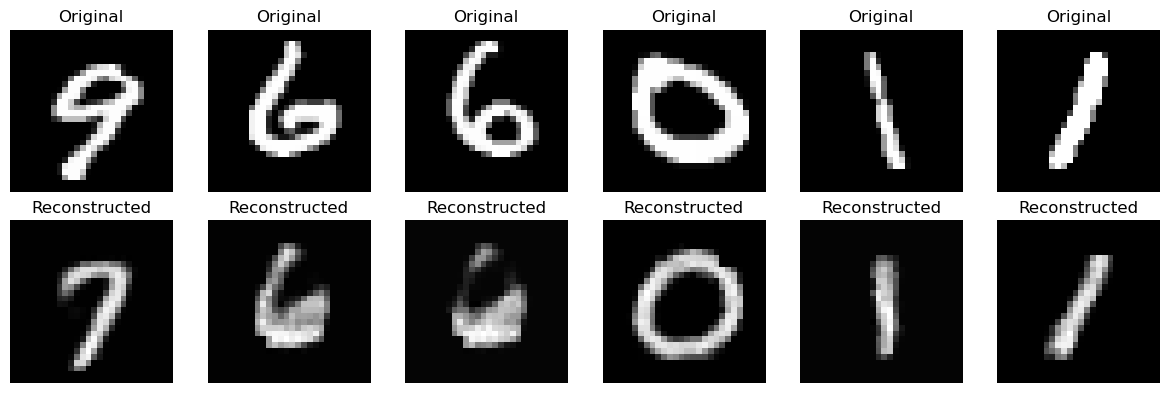

In [52]:
plot_original_vs_reconstructed(lambda_2_cnn_autoencoder, test_loader, num_samples=6)

### Lambda 32 Reconstruction for CNN Autoencoder

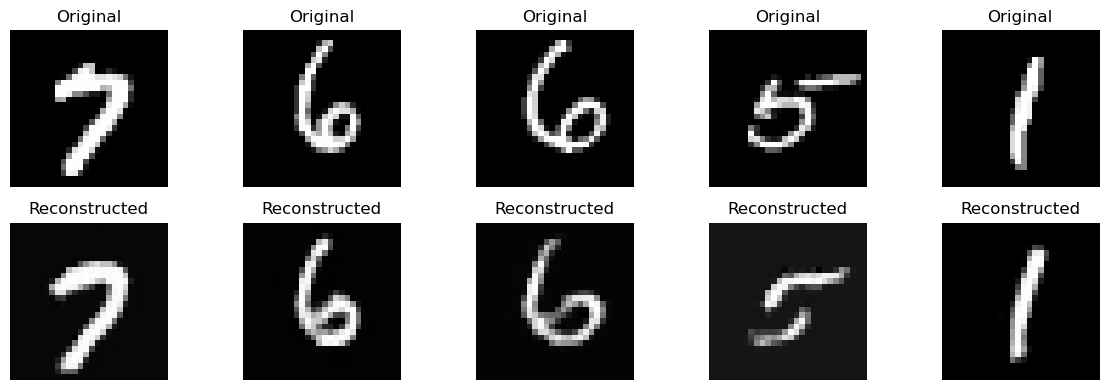

In [54]:
plot_original_vs_reconstructed(lambda_32_cnn_autoencoder, test_loader, num_samples=5)

### Training loss vs Epochs for CNN Autoencoder with same params as FC Autoencoder

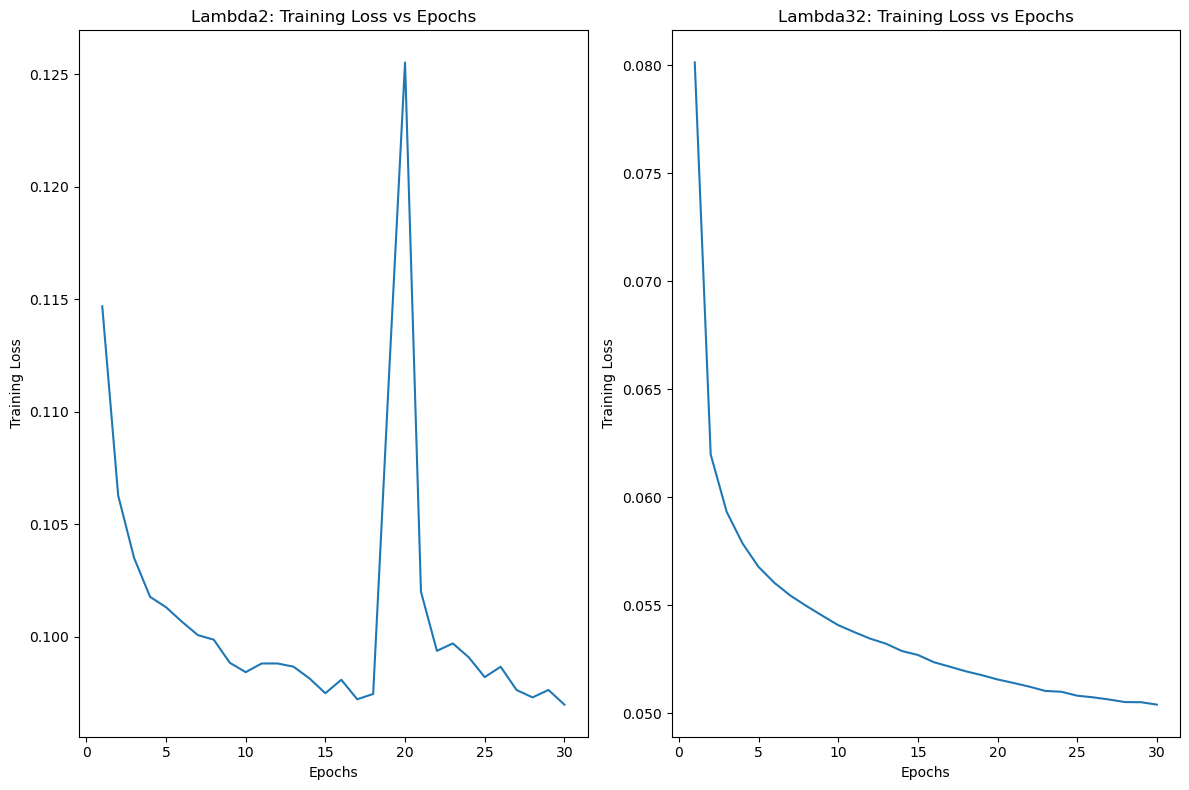

In [55]:
plot_training_loss(lambda_2_cnn_training_loss, lambda_2_cnn_epoch_numbers, lambda_32_cnn_training_loss, lambda_32_cnn_epoch_numbers)

# Interpretation


### Reconstruction Interpretation


### Training loss vs epochs Interpretation